# Guidence on applying the Simulation-CurveFitting (SCF) modules to estimate individual sampling probabilities for records with personalized privacy budgets

Steps:
- Determine the noise level sigma (aka. `noise_multiplier`) to reach a total budget of (target_epsilon, target_delta)
  at the end of training, with the given parameters.
- Instantiate a `PrivCostEstimator` object then estimate the ($\varepsilon, q$) mathematical relationship. For example:  
    `pce = PrivCostEstimator(...)`  
    `fit_fn = pce.get_sample_rate_estimator()` 
    
Note that we consider some hyper-parameter values are manually set before the training of the private model begins:
- Number of DPSGD iterations (`num_steps`)
- Per-sample gradients' clipping bound (`max_grad_norm`)
- Target DP parameters (`target_epsilons` and `target_delta`). 

Particularly, in the FL scenarios, the following variables are also considered as the hyper-parameters:
- Number of the communication rounds (`num_rounds`)
- Client-level sampling probability (`client_rate`) 

# Determine the value of `noise_multiplier`

Based on the intuition that records with the maximum sampling probability (i.e., 1.0) will reach the maximum privacy cost than the others with smaller sampling probabilities, we decide to determine the value of `noise_multiplier` via a substitutive parameter `MAX_EPSILON`. 

In [1]:
MAX_EPSILON = 10.0

We plug this parameter conbined with the other fixed ones into the function `get_noise_multiplier` to compute an optimal value of `noise_multiplier` in a binary-search way. 

Note that `get_noise_multiplier` is originally built in the [opacus](https://github.com/pytorch/opacus/blob/main/opacus/accountants/utils.py) package and we further adapt it to the FL applications (see the `myopacus.accountants.utils` module). Please refer to the following example for more details. 

In [2]:
import numpy as np
from typing import Optional
import warnings
warnings.simplefilter("ignore")
from myopacus.accountants import create_accountant

TARGET_EPSILONS = np.linspace(0.5, 2.0, num=10)
TARGET_DELTA = 1e-3
NUM_STEPS = 5
NUM_ROUNDS = 20
CLIENT_RATE = 0.5
MAX_SIGMA = 1e6

def get_noise_multiplier(
    *,
    target_epsilon: float,
    target_delta: float,
    sample_rate: float,
    epochs: Optional[int] = None,
    steps: Optional[int] = None,
    client_rate: Optional[float] = None,
    rounds: Optional[int] = None,
    accountant: str = "rdp", # "rdp" or "fed_rdp"
    epsilon_tolerance: float = 0.01,
    **kwargs,
) -> float:

    if (steps is None) == (epochs is None):
        raise ValueError(
            "get_noise_multiplier takes as input EITHER a number of steps or a number of epochs"
        )
    if steps is None:
        steps = int(epochs / sample_rate)

    eps_high = float("inf")
    accountant = create_accountant(mechanism=accountant)

    sigma_low, sigma_high = 0, 10
    while eps_high > target_epsilon:
        sigma_high = 2 * sigma_high
        accountant.history = [(sigma_high, sample_rate, client_rate, rounds, steps)]
        eps_high = accountant.get_epsilon(delta=target_delta, **kwargs)
        if sigma_high > MAX_SIGMA:
            raise ValueError("The privacy budget is too low.")

    while target_epsilon - eps_high > epsilon_tolerance:
        sigma = (sigma_low + sigma_high) / 2
        accountant.history = [(sigma, sample_rate, client_rate, rounds, steps)]
        eps = accountant.get_epsilon(delta=target_delta, **kwargs)

        if eps < target_epsilon:
            sigma_high = sigma
            eps_high = eps
        else:
            sigma_low = sigma

    return sigma_high

noise_multiplier = get_noise_multiplier(
    target_epsilon=MAX_EPSILON,
    target_delta=TARGET_DELTA,
    sample_rate=1.0,
    client_rate=CLIENT_RATE,
    steps=NUM_STEPS,
    rounds=NUM_ROUNDS,
    accountant="fed_rdp"
)
print("noise_multiplier : ", noise_multiplier)

noise_multiplier :  3.50830078125


## The RDP accountant for FedAvg-based algorithms

The original implementation of `RDPAccountant` in opacus only supports the computation of Renyi Differential Privacy (RDP) guarantees of the Sampled Gaussian Mechanism (SGM) with a record-level sampling probability $q$ (i.e., `q`) iterated $\tau$ times (i.e., `steps`), i.e., the term $\rho^{\tau}(\alpha,q)$ in the following derived RDP bound under the federated learning setting (please refer to Theorem 1 in Section 5.1 of our paper for more details).
$$ T\rho^{\tau,\lambda}(\alpha,q) 
\leq \frac{T}{\alpha-1} \ln\left\{1-\lambda+\lambda e^{(\alpha-1)\rho^{\tau}(\alpha,q)} \right\}
$$

Note that the value of $\rho_{i,j}^{\tau}(\alpha,q_{i,j})$ can be numerically calculated by directly applying the built-in function `compute_rdp` in the `opacus.accountants.analysis.rdp` module. However, there are no avaliable implementations that could handle the RDP analysis for FL cases with client-level sampling probability $\lambda$ (i.e., `client_q`) iterated $T$  communication rounds (i.e., `rounds`). We implement the following functions and include them in the package as a supplement. 

In [3]:
import math
from myopacus.accountants.analysis import rdp as privacy_analysis
from myopacus.accountants.analysis.rdp import _log_add, compute_rdp
from typing import List, Tuple, Union

def _compute_rdp_4fed(inner_rdp: float, client_q: float, rounds: int, alpha: float) -> float:
    r"""
    noise_multiplier: The ratio of the standard deviation of the
            additive Gaussian noise to the L2-sensitivity of the function
            to which it is added.
    """
    if client_q == 1.0: # no client-level privacy amplification
        return inner_rdp * rounds
    else:
        log_term_1 = np.log(1. - client_q)
        log_term_2 = np.log(client_q) + (alpha-1) * inner_rdp
        outer_rdp = _log_add(log_term_1, log_term_2)/(alpha-1)
        return outer_rdp * rounds

def compute_rdp_fed(
    *, q: float, client_q: float, noise_multiplier: float, steps: int, rounds: int, orders: Union[List[float], float]
) -> Union[List[float], float]:
    assert q >= 0.0 and q <= 1.0 and client_q >= 0.0 and client_q <= 1.0, "both the record-level and client-level sampling probability `q` and `client_q` must be a positive real number in [0,1]."
    assert steps >= 1, "The number of iterations of the SGM mechanism `steps` must be a positive integer larger than 1."
    inner_rdps = compute_rdp(q=q, noise_multiplier=noise_multiplier, steps=steps, orders=orders)
    
    if isinstance(orders, float):
        rdp = _compute_rdp_4fed(inner_rdps, client_q, rounds, orders)
    else:
        rdp = np.array([_compute_rdp_4fed(inner_rdp, client_q, rounds, order) 
                        for order, inner_rdp in zip(orders, inner_rdps)])
    return rdp

orders = privacy_analysis.generate_rdp_orders()
rdp = compute_rdp_fed(
    q=0.5, client_q=CLIENT_RATE,
    noise_multiplier=noise_multiplier,
    steps=NUM_STEPS, 
    rounds=NUM_ROUNDS,
    orders=orders
)
rdp

array([1.07433412e+00, 1.73149822e+00, 2.53537238e+00, 3.53050163e+00,
       4.73614297e+00, 6.13200112e+00, 7.66796971e+00, 9.29320472e+00,
       1.09770351e+01, 1.27098666e+01, 1.44943063e+01, 1.63373271e+01,
       1.82463354e+01, 2.02278832e+01, 2.44295511e+01, 2.66577120e+01,
       2.89745993e+01, 3.13819866e+01, 3.64710067e+01, 3.91519115e+01,
       4.47789149e+01, 4.77199865e+01, 5.38409147e+01, 6.02545399e+01,
       6.69279277e+01, 7.38280612e+01, 8.45357294e+01, 9.18720887e+01,
       1.03114405e+02, 1.14584123e+02, 1.26228908e+02, 1.38008087e+02,
       1.53869543e+02, 1.65852521e+02, 1.85940129e+02, 2.02083210e+02,
       2.18269872e+02, 2.38544309e+02, 2.62911283e+02, 2.83235464e+02,
       3.11703898e+02, 3.36111676e+02, 3.64589435e+02, 3.93066452e+02,
       4.25608874e+02, 4.62214718e+02, 4.98815860e+02, 5.39478732e+02,
       5.80136941e+02, 6.28921589e+02, 6.77701518e+02, 7.26477557e+02,
       7.83378893e+02, 8.44340654e+02, 9.05299072e+02, 9.74381977e+02,
      

Then we can obtain the corresponding list of RDP values (we name it as *DP budget curve*) given the desired ``target_delta`` and a list of RDP ``orders``. This computation is based on the "conversion from RDP to (eps, delta)-DP" theorem: If $\mathcal{A}$ is an ($\alpha,\rho$)-RDP mechanism, it also satisfies ($\rho+\frac{\log{1/\delta}}{\alpha-1},\delta$)-DP for any $0<\delta<1$.

- Borja Balle et al. (2020). Hypothesis testing interpretations and Renyi differential privacy. In International Conference on Artificial Intelligence and Statistics (AISTATS). Particullary, Theorem 21 in the [arXiv version](https://arxiv.org/abs/1905.09982).  
- Mironov, I. (2017). Rényi differential privacy. In IEEE Computer Security Foundations Symposium (CSF), Santa Barbara, California, pages 263–275.

In [4]:
orders_vec = np.atleast_1d(orders)
rdp_vec = np.atleast_1d(rdp)
# eps_vec = rdp_vec - math.log(TARGET_DELTA) / (orders_vec - 1)
eps_vec = (
    rdp_vec
    - (np.log(TARGET_DELTA) + np.log(orders_vec)) / (orders_vec - 1)
    + np.log((orders_vec - 1) / orders_vec)
)

Finally, the accumulative privacy cost is exactly the smallest $\varepsilon$ which can be derived by solving the optimization problem 
$$ \varepsilon^* \triangleq \min_{\alpha}\left\{ \rho + \frac{\log(1/\delta)}{\alpha-1}\right\}$$

In [5]:
idx_opt = np.nanargmin(eps_vec)
eps_vec[idx_opt], orders_vec[idx_opt]

(4.088177277500043, 4)

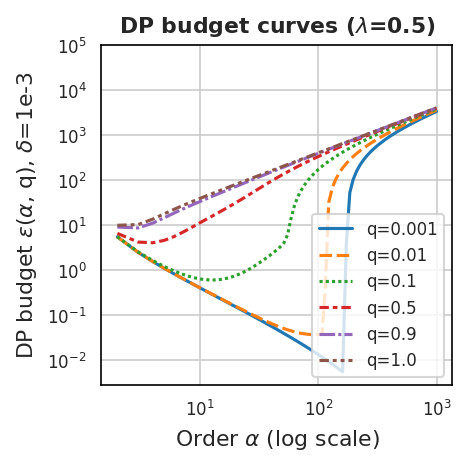

In [6]:
# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

q_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]
eps_vecs = []
for q in q_examples:
    rdp = compute_rdp_fed(
        q=q, client_q=CLIENT_RATE,
        noise_multiplier=noise_multiplier,
        steps=NUM_STEPS, 
        rounds=NUM_ROUNDS,
        orders=orders
    )
    eps_vecs.append((
        np.atleast_1d(rdp)
        - (np.log(TARGET_DELTA) + np.log(orders_vec)) / (orders_vec - 1)
        + np.log((orders_vec - 1) / orders_vec)
    ))

sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(3, 3), dpi=150, constrained_layout=True)
# dp curve w.r.t. order alpha
colname = [rf'q={q}' for q in q_examples]
df1 = pd.DataFrame(eps_vecs, columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders_vec)
sns.lineplot(data=df1_T, ax=axs)
axs.set(xscale="log", yscale="log")
axs.set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
axs.set_ylim(0, 100000)
axs.set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
axs.tick_params(labelsize=8)
axs.set_title(rf'DP budget curves ($\lambda$={CLIENT_RATE})', **title_font)
axs.legend(prop=legend_font)

Users can instantiate a `FedRDPAccountant` object and simply invoke the built-in function `get_epsilon` to obtain the accumulative privacy cost in an easy-to-use way.

In [7]:
from myopacus.accountants.fed_rdp import FedRDPAccountant

accountant = FedRDPAccountant()
accountant.history = [(noise_multiplier, 1.0, CLIENT_RATE, NUM_STEPS, NUM_ROUNDS)]
eps = accountant.get_epsilon(delta=TARGET_DELTA)
eps

11.079182321537074

We can see from the above result that if a record's sampling probability is 1.0, its accumulative privacy cost will be around 10.0 (i.e., the value of `MAX_EPSILON` that was previously pre-defined). 

# Use `PrivCostEstimator` to obtain the best-fit sampling probability estimator

After determining the noise_multiplier, we can then compute the corresponding sampling probabilities for all records based on their pre-defined privacy budgets (i.e., `target_epsilons`).

In [8]:
from pynverse import inversefunc
from myopacus.accountants.rpdp_utils import PrivCostEstimator

pce = PrivCostEstimator(
    noise_multiplier = noise_multiplier, 
    steps = NUM_STEPS, 
    rounds = NUM_ROUNDS, 
    client_rate = CLIENT_RATE,
    delta = TARGET_DELTA
)
fit_fn = pce.get_sample_rate_estimator()
sample_rates = [fit_fn(eps) for eps in TARGET_EPSILONS]
list(zip(TARGET_EPSILONS, sample_rates))

The R-Squared value of the best-fit curve : 0.999782572448225


[(0.5, 0.08135229915681517),
 (0.6666666666666666, 0.10469311662327863),
 (0.8333333333333333, 0.12760749376678526),
 (1.0, 0.15011073368242106),
 (1.1666666666666665, 0.1722173311781001),
 (1.3333333333333333, 0.1939410233080957),
 (1.5, 0.21529485397764742),
 (1.6666666666666665, 0.2362912049884681),
 (1.8333333333333333, 0.25694184635207606),
 (2.0, 0.27725798162213433)]

## The trade-off between noise and sampling error

It is clear that there is a trade-off between the noise and sampling errors: the larger the `MAX_EPSILON`, the smaller the sampling probability (but below 1.0) for all records, as shown in the follwing example.

In [9]:
MAX_EPSILON_LIST = [10, 20, 30, 40, 50]
q_eps_fit_param_list = []
q_eps_fit_fn_list = []
examples_list = []
q_candidates = None
for max_epsilon in MAX_EPSILON_LIST:
    nm = get_noise_multiplier(
        target_epsilon=max_epsilon,
        target_delta=TARGET_DELTA,
        sample_rate=1.0,
        client_rate=CLIENT_RATE,
        steps=NUM_STEPS,
        rounds=NUM_ROUNDS,
        accountant="fed_rdp"
    )
    pce = PrivCostEstimator(
        noise_multiplier = nm, 
        steps = NUM_STEPS, 
        rounds = NUM_ROUNDS, 
        client_rate = CLIENT_RATE,
        delta = TARGET_DELTA
    )
    fit_fn = pce.get_sample_rate_estimator()
    if q_candidates is None:
        q_candidates = pce.q_candidates

    q_eps_fit_param_list.append(pce.q_eps_fit_param)
    q_eps_fit_fn_list.append(pce.q_eps_fit_fn)
    examples_list.append(pce.examples)

The R-Squared value of the best-fit curve : 0.999782572448225
The R-Squared value of the best-fit curve : 0.9994708002891884
The R-Squared value of the best-fit curve : 0.9994866209035956
The R-Squared value of the best-fit curve : 0.9996553896913688
The R-Squared value of the best-fit curve : 0.9997401120641882


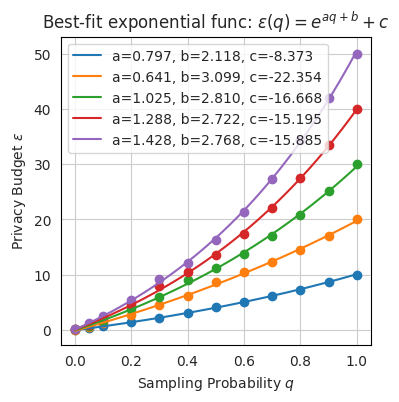

In [10]:
# Here we just demo a subset of points (observations) for a more clear illustration
idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]

plt.figure(num=1, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(q_eps_fit_fn_list)):
    plt.scatter(np.array(q_candidates)[idx], np.array(examples_list[i])[idx], linewidth=1)
    plt.plot(q_candidates, [q_eps_fit_fn_list[i](q) for q in q_candidates], '-', label='a=%5.3f, b=%5.3f, c=%5.3f' % tuple(q_eps_fit_param_list[i]))

plt.title(r'Best-fit exponential func: $\varepsilon(q)=e^{aq+b}+c$')
plt.xlabel(rf'Sampling Probability $q$')
plt.ylabel(rf'Privacy Budget $\epsilon$')
plt.legend()
plt.grid(True)
plt.show()

We can increase the `noise_multiplier` (which leads to a smaller sampling rate for all records) by increasing the hyper-parameter `MAX_EPSILON`.